In [1]:
import numpy as np
from tqdm import tqdm
import yfinance as yf
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
# List of yfinance-compatible tickers
tickers = [
    "^N225",    # S&P 500 Index
      # iShares U.S. Real Estate ETF (Morgan Stanley REIT Index)
]

# Download monthly returns data for the last 14 years
start_date = "2003-03-01"
end_date = "2016-04-01"

# Fetch monthly data for each ticker
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date, interval='1mo', progress=False)['Adj Close']
    returns = data.pct_change().dropna() * 100  # Calculate monthly returns
dates = returns.index

### Define Distribution Functions

In [3]:
def N(mean, variance, size = None):
    return np.random.normal(mean, np.sqrt(variance), size)

def U(start_point, end_point, size = None):
    return np.random.uniform(start_point, end_point, size)

def B(α, β, size = None):
    return np.random.beta(α, β, size)

### Define Observation Functions

In [4]:
def SOSS_update(α, θ):  
    return N(α * θ + (1 - α) * np.mean(θ), (1 - α**2) * np.var(θ))

In [5]:
def x_transition_function(x̄, ϕ_x, σ_x, ξ_t, x_t):
    particles = x̄ + ϕ_x * (x_t - x̄) + σ_x * ξ_t
    return particles

In [6]:
def μ_transition_function(y_t, ϕ_μ, σ_μ, η_μ, μ_t):
    particles = y_t + ϕ_μ * (μ_t - y_t) + σ_μ * η_μ
    return particles

In [7]:
def observation_function(μ_t, x_t, ϵ_t):
    y_t = μ_t + np.exp(x_t / 2) * ϵ_t
    return y_t

In [8]:
def observation_likelihood(y, μ, x):
    σ_t = np.exp(x / 2)

    likelihood = (1 / (np.sqrt(2 * np.pi) * σ_t)) * np.exp(- ((y - μ)**2) / (2 * σ_t**2))

    return likelihood

### Constant Parameters

In [9]:
observation = Y = returns.values
Y_train = Y[:48]

In [10]:
L = 1_000_000 # number of particles
T = len(Y) # number of time steps
δ = 0.98
α_shrink_factor = (3 * δ - 1) / (2 * δ)

In [11]:
α_parameter = np.full(L, np.mean(Y[:24])) # mean of first 2 year return shape (L, 1)

### Variables

In [12]:
x = np.zeros((T, L)) # latent x, shape (T, L)
p_x = np.zeros((T, L)) # particles of latent x, shape (T, L)
x̄ = np.zeros((T, L))
p_x̄ = np.zeros((T, L))
ϕ_x = np.zeros((T, L))
p_ϕ_x = np.zeros((T, L))
σ_x = np.zeros((T, L))
p_σ_x = np.zeros((T, L))

μ = np.zeros((T, L)) # latent μ, shape (T, L)
p_μ = np.zeros((T, L)) # particles of latent μ, shape (T, L)
ϕ_μ = np.zeros((T, L))
p_ϕ_μ = np.zeros((T, L))
σ_μ = np.zeros((T, L))
p_σ_μ = np.zeros((T, L))

α = np.zeros((T, L)) # weights, shape (T, L)
y = np.zeros((T, L)) # estimation of return, shape (T, L)


ξ = np.zeros((T, L)) # latent x noise, shape (T, L)
η = np.zeros((T, L)) # latent μ noise, shape (T, L)
ϵ = np.zeros((T, L)) # observation noise, shape (T, L)

### initialize

In [13]:
x̄[0] = U(-1, 5, L)
ϕ_μ[0] =  U(0, 1, L)
ϕ_x[0] = 2 * B(20, 1.5, L) - 1
σ_x[0] = U(0, 2, L)

σ_μ[0] = U(0, np.std(Y_train), L) # shape (L, 1)


x[0] = N(x̄[0], (σ_x[0] ** 2) / (1 - ϕ_x[0] ** 2))
μ[0] = N(α_parameter, (σ_μ[0] ** 2) / (1 - ϕ_μ[0] ** 2))

ϵ[0] = N(0, 1, L)
y[0] = observation_function(μ[0], x[0], ϵ[0])

### Particle Filtering Loop

In [14]:
for t in tqdm(range(1, T, 1)):
    # SOSS update
    p_x̄[t] = SOSS_update(α_shrink_factor, x̄[t-1])
    p_ϕ_x[t] = SOSS_update(α_shrink_factor, ϕ_x[t-1])
    p_σ_x[t] = SOSS_update(α_shrink_factor, σ_x[t-1])
    p_σ_μ[t] = SOSS_update(α_shrink_factor, σ_μ[t-1])
    p_ϕ_μ[t] = SOSS_update(α_shrink_factor, ϕ_μ[t-1])

    # generate system noise and calculate particles for x
    ξ[t] = N(0, 1, L)
    p_x[t] = x_transition_function(p_x̄[t], p_ϕ_x[t], p_σ_x[t], ξ[t], x[t-1])
    
    # generate system noise and calculate particles for μ
    η[t] = N(0, 1, L)
    p_μ[t] = μ_transition_function(observation[t-1], p_ϕ_μ[t], p_σ_μ[t], η[t], μ[t-1])


    # generate noise and calculate expected observations
    ϵ[t] = N(0, 1, L)
    y[t] = observation_function(p_μ[t], p_x[t], ϵ[t])


    # calculate likelihood with Gaussian likelihood
    α[t] = observation_likelihood(observation[t], p_μ[t], p_x[t])
    

    # calculate the weights as the normalized likelihoods
    weights = α[t].copy()
    weights /= np.sum(α[t])

    # Resample everything from the particles
    cumulative_sum = np.cumsum(weights)
    positions = (np.arange(L) + np.random.uniform(0, 1)) / L
    sample_indices = np.searchsorted(cumulative_sum, positions)

    x[t] = p_x[t, sample_indices]
    μ[t] = p_μ[t, sample_indices]
    x̄[t] = p_x̄[t, sample_indices]
    ϕ_x[t] = p_ϕ_x[t, sample_indices]
    σ_x[t] = p_σ_x[t, sample_indices]
    ϕ_μ[t] = p_ϕ_μ[t, sample_indices]
    σ_μ[t] = p_σ_μ[t, sample_indices]


100%|██████████| 155/155 [00:54<00:00,  2.83it/s]


### AD1

/var/folders/hc/3xpjq4rs4qq1sf838pqb80780000gn/T/ipykernel_69362/1682943591.py:2: RuntimeWarning: divide by zero encountered in log
  log_likelihood = np.log(np.mean(α, axis=1))


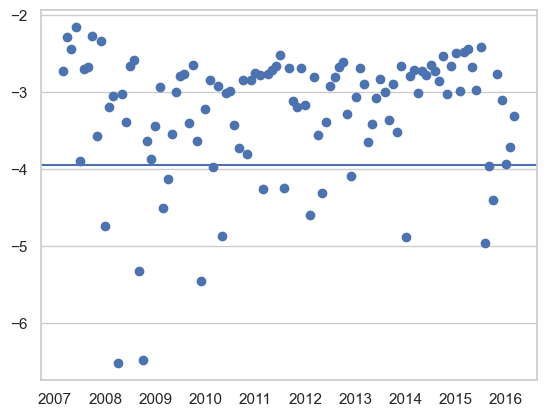

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0])

In [22]:
# define the log likelihood at time t by l(yt) ≡ log p(yt|Zt) which is approximately calculated with taking log of the right hand side of 
log_likelihood = np.log(np.mean(α, axis=1))

# threshold is set to be about the 5 percentile of {l(yt )}t=6,...,47, which corresponds to the second lowest value in {l(yt )}t=6,...,47.
threshold = np.sort(log_likelihood[6:48])[1]

plt.scatter(dates[47:], log_likelihood[47:])
plt.axhline(y=threshold)
plt.show()
# if l(yt) takes a lower value than a predetermined threshold at time t, we regard yt as an anomaly.
AD1 = (log_likelihood[48:] < threshold).astype(int)
AD1

### AD2

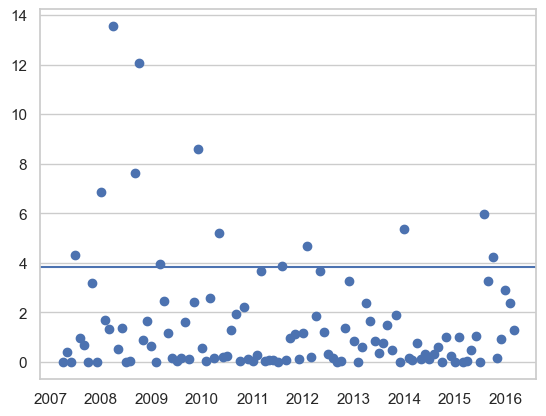

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [23]:
from scipy.stats import chi2
AD2 = np.exp(- np.median(p_x, axis=1)) * ((observation - np.median(p_μ, axis=1)) ** 2)
threshold = chi2.ppf(0.95, df=1)
plt.scatter(dates[48:], AD2[48:])
plt.axhline(y=threshold)
plt.show()
AD2 = (AD2[48:] >= threshold).astype(int)
AD2

### AD3

In [25]:
# Compute percentiles for each row of y
percentile_2_5 = np.percentile(y, 2.5, axis=1)  # 2.5th percentile for each row
percentile_97_5 = np.percentile(y, 97.5, axis=1)  # 97.5th percentile for each row

# Check if observation lies within the percentile range
AD3 = (observation >= percentile_2_5) & (observation <= percentile_97_5)
AD3 = np.where(AD3, 0, 1)
AD3 = AD3[48:]
AD3

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

### Plots

In [19]:
# Function to compute median and percentiles
def compute_stats(data):
    median = np.median(data, axis=1)
    lower_percentile = np.percentile(data, 2.5, axis=1)
    upper_percentile = np.percentile(data, 97.5, axis=1)
    return median, lower_percentile, upper_percentile

x̄_median, x̄_lower, x̄_upper = compute_stats(x̄)
ϕ_μ_median, ϕ_μ_lower, ϕ_μ_upper = compute_stats(ϕ_μ)
ϕ_x_median, ϕ_x_lower, ϕ_x_upper = compute_stats(ϕ_x)
σ_x_median, σ_x_lower, σ_x_upper = compute_stats(σ_x)
σ_μ_median, σ_μ_lower, σ_μ_upper = compute_stats(σ_μ)

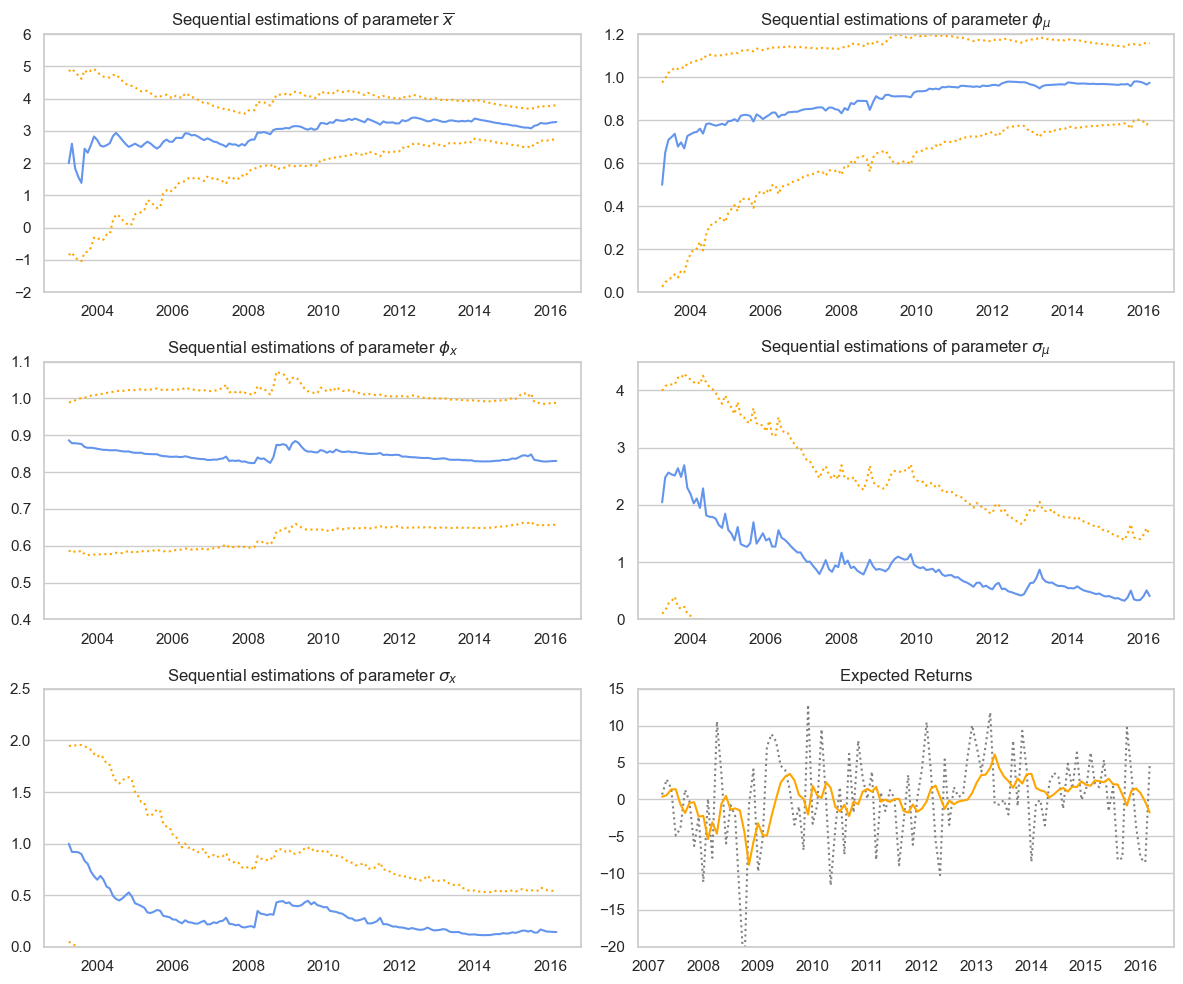

In [24]:
# Create the 2x3 subplot structure
sns.set_theme(style="whitegrid")  # Start with "whitegrid" style
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"  # Limit the grid to only horizontal lines

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Sequential estimations of x̄
axes[0, 0].plot(dates, x̄_median, label="Median", color="cornflowerblue")
axes[0, 0].plot(dates, x̄_lower, linestyle="dotted", color="orange")
axes[0, 0].plot(dates, x̄_upper, linestyle="dotted", color="orange")
axes[0, 0].set_title("Sequential estimations of parameter $\overline{x}$")
axes[0, 0].set_ylim(-2, 6)

# Sequential estimations of ϕ_μ
axes[0, 1].plot(dates, ϕ_μ_median, label="Median", color="cornflowerblue")
axes[0, 1].plot(dates, ϕ_μ_lower, linestyle="dotted", color="orange")
axes[0, 1].plot(dates, ϕ_μ_upper, linestyle="dotted", color="orange")
axes[0, 1].set_title("Sequential estimations of parameter $\phi_\mu$")
axes[0, 1].set_ylim(0, 1.2)

# Sequential estimations of ϕ_x
axes[1, 0].plot(dates, ϕ_x_median, label="Median", color="cornflowerblue")
axes[1, 0].plot(dates, ϕ_x_lower, linestyle="dotted", color="orange")
axes[1, 0].plot(dates, ϕ_x_upper, linestyle="dotted", color="orange")
axes[1, 0].set_title("Sequential estimations of parameter $\phi_x$")
axes[1, 0].set_ylim(0.4, 1.1)

# Sequential estimations of σ_μ
axes[1, 1].plot(dates, σ_μ_median, label="Median", color="cornflowerblue")
axes[1, 1].plot(dates, σ_μ_lower, linestyle="dotted", color="orange")
axes[1, 1].plot(dates, σ_μ_upper, linestyle="dotted", color="orange")
axes[1, 1].set_title("Sequential estimations of parameter $\sigma_\mu$")
axes[1, 1].set_ylim(0, 4.5)

# Sequential estimations of σ_x
axes[2, 0].plot(dates, σ_x_median, label="Median", color="cornflowerblue")
axes[2, 0].plot(dates, σ_x_lower, linestyle="dotted", color="orange")
axes[2, 0].plot(dates, σ_x_upper, linestyle="dotted", color="orange")
axes[2, 0].set_title("Sequential estimations of parameter $\sigma_x$")
axes[2, 0].set_ylim(0, 2.5)

# Expected returns
axes[2, 1].plot(dates[48:], observation[48:], linestyle="dotted", color="grey")
axes[2, 1].plot(dates[48:], np.median(y, axis=1)[48:], color="orange")
axes[2, 1].set_title("Expected Returns")
axes[2, 1].set_ylim(-20, 15)

# Adjust layout
plt.tight_layout()
plt.show()